# Занятие 4: Вычисление атомных орбиталей водорода

### Лев Мазаев, мАДБМ18

In [1]:
import numpy as np
import scipy.special
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xmlrpc.client as xmlrpclib
import time
cmd = xmlrpclib.ServerProxy('http://localhost:9123')
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
def npy2cube(grid, start, step, cube_f):
    '''
    PARAMETERS:
        grid : numpy array
            3-dimentional array, containing grid data
        start : tuple
            format: (x, y, z), coordinates of cube start point
        step: tuple
            format: (x, y, z), step size on 3 axes 
        cube_f: string
             name of output .cube file
    
    RETURNS:
        void    
    '''
    
    cube_string = ""
    bohr_to_angs = 0.529177210859  # const
    start = list(map(lambda x: x/bohr_to_angs, start))
    step = list(map(lambda x: x/bohr_to_angs, step))

    with open(cube_f, "w") as cube_file:
        ###HEADER###
        cube_file.write(" CPMD CUBE FILE.\nOUTER LOOP: X, MIDDLE LOOP: Y, INNER LOOP: Z\n")
        cube_file.write("    1 %f %f %f\n" %(start[0], start[1], start[2]))
        cube_file.write("  %i    %f   0.000000     0.000000\n" %(grid.shape[0], step[0]))
        cube_file.write("  %i    0.000000    %f    0.000000\n" %(grid.shape[1], step[1]))
        cube_file.write("  %i    0.000000    0.000000    %f\n" %(grid.shape[2], step[2]))
        cube_file.write("    1    0.000000    %f %f %f\n" %(start[0], start[1], start[2]))

        ###DATA###
        i = 0
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                for z in range(grid.shape[2]):
                    if i < 5:
                        cube_file.write("%f " %(float(grid[x, y, z])))
                        i += 1
                    elif i == 5:
                        cube_file.write("%f\n" %(float(grid[x, y, z])))
                        i = 0
    return 0

Необходимо подправить волновую функцию, так как в ней не хватает выделенной составляющей.

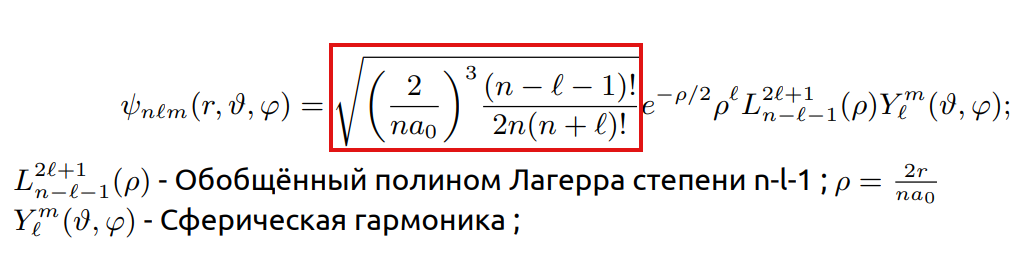

In [3]:
Image('scr1.png')

Вычисление этой составляющей записывается в переменную `sqt`.

In [4]:
def w(n, l, m, d):

    # Увеличил число точек, так картинки получаются гораздо красивее
    x, y, z = np.mgrid[-d:d:100j,-d:d:100j,-d:d:100j]
    
    # В следующих 3 функциях осуществляется переход в сферические координаты
    r = lambda x, y ,z: np.sqrt(x**2+y**2+z**2)  # радиус
    theta = lambda x, y, z: np.arccos(z / r(x,y,z))  # угол θ (полярный)
    phi = lambda x, y, z: np.arctan(y / x)  # угол φ (азимутальный)

    a0 = 1.0  # Боровский радиус
    
    # Добавленная константа
    sqt = ((2 / n / a0)**3 * np.math.factorial(n - l - 1) / 2 / n / np.math.factorial(n + l)) ** 0.5
    
    # Константа ρ
    p = lambda r: 2 * r / n / a0  
    
    # Радиальная часть волновой функции
    R = lambda r, n, l: sqt * p(r)**l * np.exp(-p(r) / 2) * \
    scipy.special.genlaguerre(n - l - 1, 2 * l + 1)(p(r))
    
    # Угловая часть волновой функции
    WF = lambda r, theta, phi, n, l, m: R(r, n, l) * scipy.special.sph_harm(m, l, phi, theta)
    
    # Квадрат волновой функции (плотность вероятности нахождения электрона в данной точке)
    absWF = lambda r, theta, phi, n, l, m: np.absolute(WF(r, theta, phi, n, l, m)**2)

    return WF(r(x, y, z), theta(x, y, z), phi(x,y,z), n, l, m)

Посчитаем значения для первых четырёх уровней.

In [5]:
d = 50
step = 2 * d / 99
cube_loc = './cubes/'

quantum_numbers = []
for n in range(0, 5):
    for l in range(0, n):
        for m in range(0, l+1):
            grid = w(n, l, m, d)
            quantum_numbers.append(f'{n}-{l}-{m}')
            name=f'{n}-{l}-{m}'
            npy2cube(grid, (-d, -d, -d), (step, step, step), cube_loc + name + '.cube')

Настроим окраску так, что положительные значения будут окрашиваться в **красный**, отрицательные - в **синий**.

In [6]:
cmd.do('reinitialize')
cmd.volume_ramp_new('ramp', [\
     -0.00040, 0.40, 0.40, 1.00, 0.00, \
     -0.00030, 0.40, 0.40, 1.00, 0.15, \
     -0.00025, 0.40, 0.40, 1.00, 0.00, \
      0.00025, 1.00, 0.40, 0.40, 0.00, \
      0.00030, 1.00, 0.40, 0.40, 0.15, \
      0.00040, 1.00, 0.40, 0.40, 0.00, \
])

Визуализируем все файлы в PyMol:

In [7]:
img_loc = './images/'

for c in quantum_numbers:
    name = cube_loc + c + '.cube'
    cmd.do(f'''
    reinitialize
    load {name}, raw
    volume vol, raw
    volume_color vol, ramp    
    ''')
    time.sleep(0.2)
    cmd.do(f'''
    turn x, 60
    turn y, 45
    draw 1600, 1200
    png {img_loc}img{c}.png
    ''')
    time.sleep(0.2)

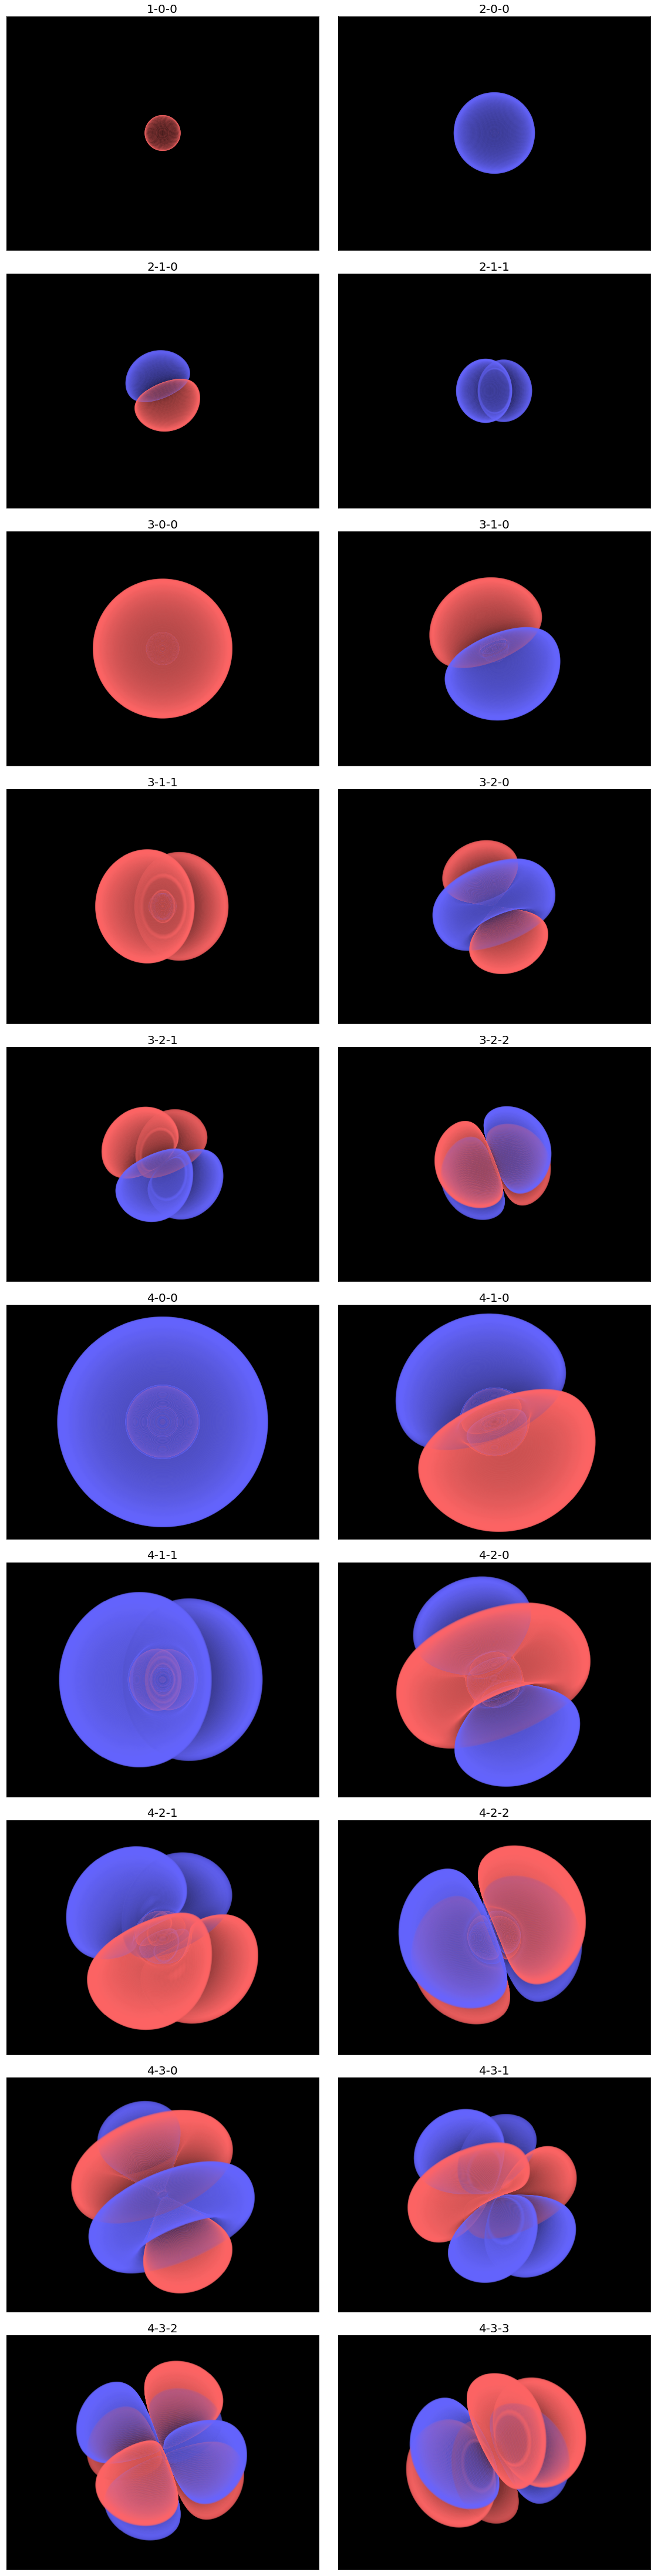

In [8]:
%matplotlib inline

nimg = len(quantum_numbers)
plt.figure(figsize=(20, 80))
for i in range(nimg):
    name = img_loc + f'img{quantum_numbers[i]}.png'
    plt.subplot(nimg // 2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(name))
    plt.title(quantum_numbers[i], fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.subplots_adjust(wspace=0.025, hspace=0.1)
plt.show()

Красный цвет - положительное значение волновой функции, синий - отрицательное.

Теперь проделаем расчёты в ORCA. Для начала создадим входной файл.
Согласно мануалу второй параметр функции MO() - номер орбитали, и он начинается с 0.

In [9]:
with open('h.inp', "w") as inp:
    inp.write('! UHF SVP XYZFile\n')
    inp.write('%plots Format Cube\n')
    for i, name in enumerate(quantum_numbers):
        inp.write(f' MO("./co/{name}.cube", {i}, 0);\n')
    inp.write('end\n')
    inp.write('* xyz 0 4\n')
    inp.write(' H 0 0 0\n')
    inp.write('*')

In [10]:
! cat h.inp

! UHF SVP XYZFile
%plots Format Cube
 MO("./co/1-0-0.cube", 0, 0);
 MO("./co/2-0-0.cube", 1, 0);
 MO("./co/2-1-0.cube", 2, 0);
 MO("./co/2-1-1.cube", 3, 0);
 MO("./co/3-0-0.cube", 4, 0);
 MO("./co/3-1-0.cube", 5, 0);
 MO("./co/3-1-1.cube", 6, 0);
 MO("./co/3-2-0.cube", 7, 0);
 MO("./co/3-2-1.cube", 8, 0);
 MO("./co/3-2-2.cube", 9, 0);
 MO("./co/4-0-0.cube", 10, 0);
 MO("./co/4-1-0.cube", 11, 0);
 MO("./co/4-1-1.cube", 12, 0);
 MO("./co/4-2-0.cube", 13, 0);
 MO("./co/4-2-1.cube", 14, 0);
 MO("./co/4-2-2.cube", 15, 0);
 MO("./co/4-3-0.cube", 16, 0);
 MO("./co/4-3-1.cube", 17, 0);
 MO("./co/4-3-2.cube", 18, 0);
 MO("./co/4-3-3.cube", 19, 0);
end
* xyz 0 4
 H 0 0 0
*

Затем после загрузки файла h.inp выполняем на сервере в терминале следующие команды:
```bash
mkdir co
orca h.inp > h.out
tar -czvf cubes.tar.gz ./co/*
```
И скачиваем архив для просмотра получившихся результатов в PyMol.

ORCA корректно считает только первые 5 файлов, причём, судя по всему, они соответствуют следующим наборам квантовых чисел, так как 3 среди этих 5 файлов 3 p-орбитали.

- 1 0 0
- 2 0 0
- 2 1 -1
- 2 1 0
- 2 1 1

Следовательно, переименуем их по порядку и приступим к визуализации.

In [11]:
img_loc_orca = './orca_images/'

qnn = quantum_numbers[:4] + ['2-1--1']
for c in qnn:
    name = './orca/' + c + '.cube'
    cmd.do(f'''
    reinitialize
    load {name}, raw
    volume vol, raw
    volume_color vol, ramp    
    ''')
    time.sleep(0.2)
    cmd.do(f'''
    turn x, 60
    turn y, 45
    draw 1600, 1200
    png {img_loc_orca}img{c}.png
    ''')
    time.sleep(0.2)

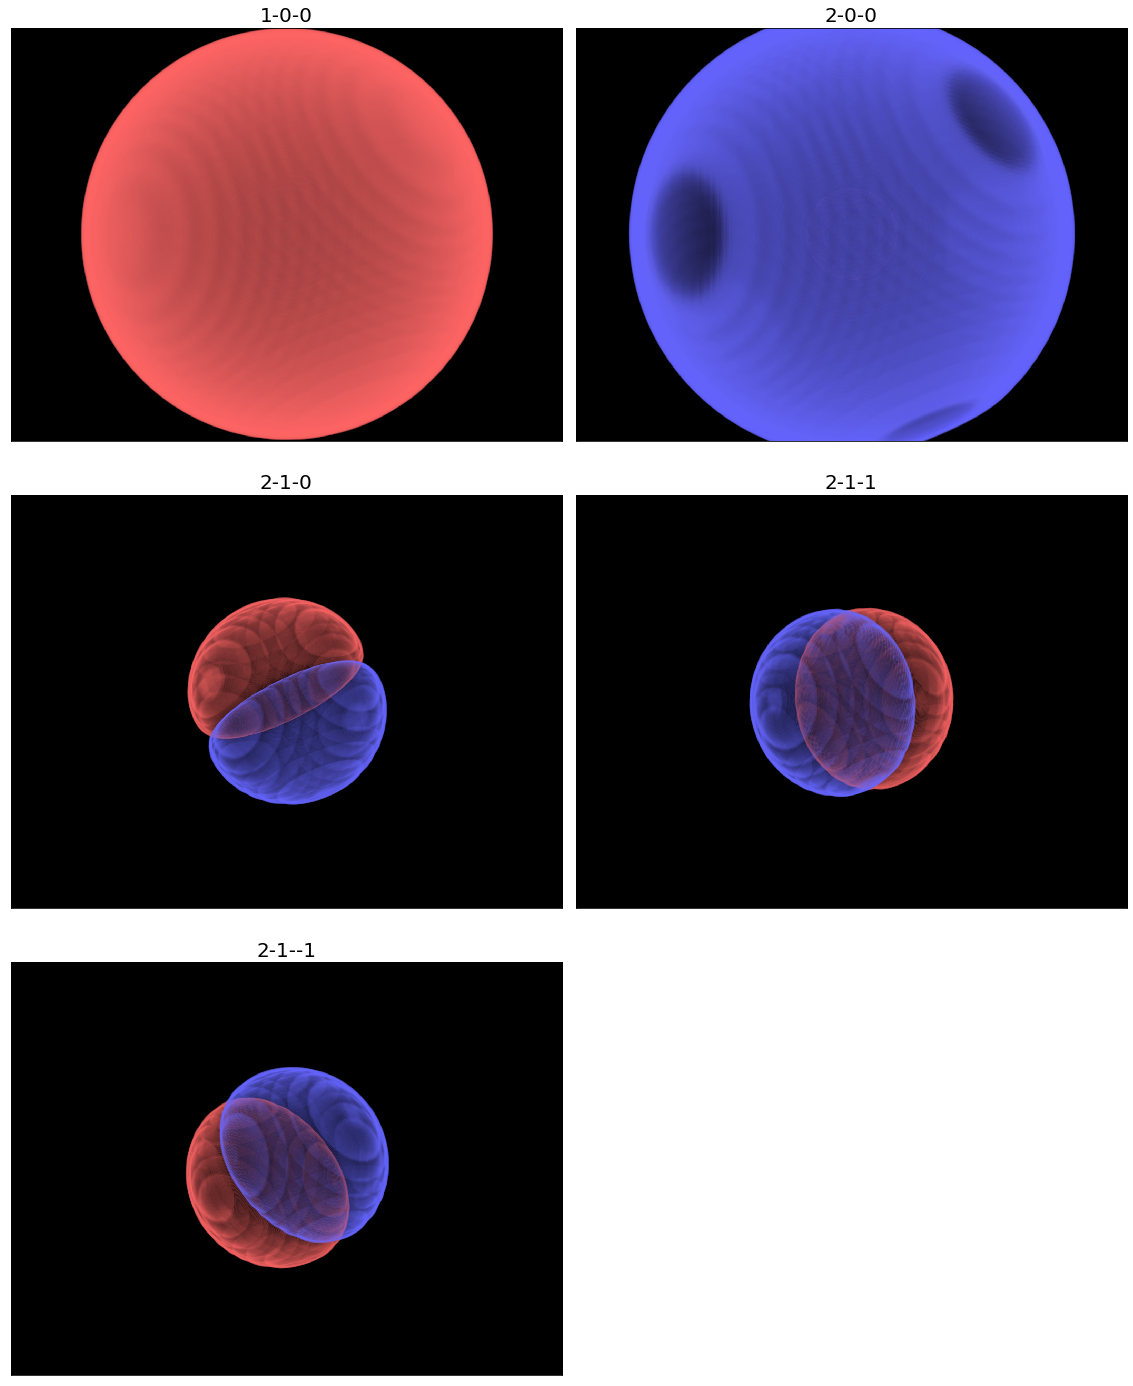

In [12]:
%matplotlib inline

plt.figure(figsize=(20, 25))
for i in range(5):
    name = img_loc_orca + f'img{qnn[i]}.png'
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(name))
    plt.title(qnn[i], fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.subplots_adjust(wspace=0.025, hspace=0.1)
plt.show()

По форме орбитали совпадают, а вот у p-орбиталей в случае расчёта при помощи ORCA не видно изменения знака на p-орбиталях при изменении квантовых чисел. Возможно, дело во третьем аргументе (оператор 0 или 1) функции MO()? Попробовал менять этот аргумент - орбитали остались такими же.